### collapse data

In [1]:
import pandas, math
from collections import defaultdict
%matplotlib inline

In [2]:
fg_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.splitPfam.dat'
bg_file = '../data/interim/r1_no_tcga/exac.tidy.eff.dbnsfp.gt.anno.hHack.splitPfam.dat'
df_exac_pre = pandas.read_csv(bg_file, sep='\t')
max_exac_an = max(df_exac_pre['an'].values)

df_fg_pre = pandas.read_csv(fg_file, sep='\t')
max_fg = max([p+2*n for p,n in df_fg_pre[['pos_fam', 'neg_fam']].values])
df_exac = df_exac_pre[df_exac_pre['af_1kg_all'] < .01]
df_fg = df_fg_pre[df_fg_pre['af_1kg_all'] < .01]

# don't forget to add non-var counts
var = 'missense_variant'
cols = ['pfam', 'chrom', 'pos']
pfam_to_exac_pos = defaultdict(dict)
for pfam, chrom, pos in list(df_exac[df_exac.eff==var][cols].values):
    pfam_to_exac_pos[pfam][str(chrom) + ':' + str(pos)] = True
pfam_to_fg_pos = defaultdict(dict)
for pfam, chrom, pos in list(df_fg[df_fg.eff==var][cols].values):
    pfam_to_fg_pos[pfam][str(chrom) + ':' + str(pos)] = True

missing_exac_count = []
for pfam in pfam_to_fg_pos:
    if not pfam in pfam_to_exac_pos:
        ls = [pfam, len(pfam_to_fg_pos[pfam])]
        missing_exac_count.append(ls)
    else:
        miss_len = len( set(pfam_to_fg_pos[pfam]) - set(pfam_to_exac_pos[pfam]) )
        ls = [pfam, miss_len]
        missing_exac_count.append(ls)
missing_exac_df = pandas.DataFrame({'pfam':[x[0] for x in missing_exac_count],
                                    'miss_exac':[x[1] for x in missing_exac_count]})        
missing_fg_count = []
for pfam in pfam_to_exac_pos:
    if not pfam in pfam_to_fg_pos:
        ls = [pfam, len(pfam_to_exac_pos[pfam])]
        missing_fg_count.append(ls)
    else:
        miss_len = len( set(pfam_to_exac_pos[pfam]) - set(pfam_to_fg_pos[pfam]) )
        ls = [pfam, miss_len]
        missing_fg_count.append(ls)
missing_fg_df = pandas.DataFrame({'pfam':[x[0] for x in missing_fg_count],
                                  'miss_fg':[x[1] for x in missing_fg_count]})

missing_df = pandas.merge(missing_fg_df, missing_exac_df, on='pfam', how='outer').fillna(0)

#fg_pos = set([chrom + ':' + pos for chrom, pos in df_fg[df_fg.eff==var][cols].values])
#missing_exac_count = len(fg_pos) - len(exac_pos)

cols = ['ac', 'an']
g_exac = df_exac[df_exac.eff==var].groupby('pfam')[cols].sum().reset_index()
#g_exac.head()

fg_cols = ['pos_fam', 'neg_fam']
g_fg = df_fg[df_fg.eff==var].groupby('pfam')[fg_cols].sum().reset_index()
#g_fg.head()

m_pre = pandas.merge(g_fg, g_exac, on='pfam', how='outer').fillna(0)
m = pandas.merge(m_pre, missing_df, on='pfam', how='left')
print(max_exac_an, max_fg)
#m.head()

def calc_fg_neg(row, max_fg):
    return 2*row['neg_fam'] + max_fg*row['miss_fg'] + row['pos_fam']

def calc_bg_neg(row, max_exac):
    return row['an'] + max_exac*row['miss_exac']

m.loc[:, 'fg_tot'] = m.apply(lambda row: calc_fg_neg(row, max_fg), axis=1)
m.loc[:, 'bg_tot'] = m.apply(lambda row: calc_bg_neg(row, max_exac_an), axis=1)
m['fg_frac'] = (1+m['pos_fam']) / m['fg_tot']
m['fg_frac_log'] = m.apply(lambda row: math.log(row['fg_frac'], 2), axis=1)
m['bg_frac'] = (1+m['ac']) / m['bg_tot']
m['bg_frac_log'] = m.apply(lambda row: math.log(row['bg_frac'], 2), axis=1)
m['fg_other'] = m['fg_tot'] - m['pos_fam']
m['bg_other'] = m['bg_tot'] - m['ac']
m.head()

/opt/conda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


106210 17165


,pfam,pos_fam,neg_fam,ac,an,miss_fg,miss_exac,fg_tot,bg_tot,fg_frac,fg_frac_log,bg_frac,bg_frac_log,fg_other,bg_other
0,A1_Propeptide:4,17.0,42708.0,90.0,1593100.0,12.0,2.0,291413.0,1805520.0,0.000062,-13.982781,0.000050,-14.276188,291396.0,1805430.0
1,ANF_receptor:66,18.0,34674.0,768.0,8273946.0,20.0,1.0,412666.0,8380156.0,0.000046,-14.406688,0.000092,-13.411706,412648.0,8379388.0
2,Aldedh:172,98.0,14508.0,2802.0,637248.0,0.0,0.0,29114.0,637248.0,0.003400,-8.200069,0.004399,-7.828739,29016.0,634446.0
3,Aldedh:173,5.0,21904.0,99.0,2867658.0,5.0,0.0,129638.0,2867658.0,0.000046,-14.399167,0.000035,-14.807585,129633.0,2867559.0
4,Aldedh:174,2.0,14604.0,6.0,637260.0,2.0,2.0,63540.0,849680.0,0.000047,-14.370415,0.000008,-16.889205,63538.0,849674.0


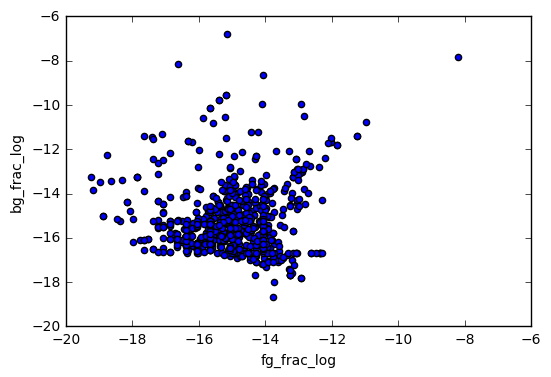

In [3]:
m.plot.scatter('fg_frac_log', 'bg_frac_log')

In [4]:
df_fg[df_fg.eff==var].head()

,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam
0,1,40539750,T,C,VUS,Palm_thioest:0,0.000399,missense_variant,16,8529
1,1,40539750,T,C,VUS,Palm_thioest:1,0.000399,missense_variant,16,8529
2,1,40539840,T,G,VUS,Palm_thioest:0,0.000000,missense_variant,1,8544
3,1,40539840,T,G,VUS,Palm_thioest:1,0.000000,missense_variant,1,8544
4,1,40542543,G,T,VUS,Palm_thioest:3,0.000200,missense_variant,1,8544


In [7]:
m[['fg_frac', 'bg_frac']].corr()

,fg_frac,bg_frac
fg_frac,1.000000,0.368533
bg_frac,0.368533,1.000000


In [8]:
m.head()

,pfam,pos_fam,neg_fam,ac,an,miss_fg,miss_exac,fg_tot,bg_tot,fg_frac,fg_frac_log,bg_frac,bg_frac_log,fg_other,bg_other
0,A1_Propeptide:4,17.0,42708.0,90.0,1593100.0,12.0,2.0,291413.0,1805520.0,0.000062,-13.982781,0.000050,-14.276188,291396.0,1805430.0
1,ANF_receptor:66,18.0,34674.0,768.0,8273946.0,20.0,1.0,412666.0,8380156.0,0.000046,-14.406688,0.000092,-13.411706,412648.0,8379388.0
2,Aldedh:172,98.0,14508.0,2802.0,637248.0,0.0,0.0,29114.0,637248.0,0.003400,-8.200069,0.004399,-7.828739,29016.0,634446.0
3,Aldedh:173,5.0,21904.0,99.0,2867658.0,5.0,0.0,129638.0,2867658.0,0.000046,-14.399167,0.000035,-14.807585,129633.0,2867559.0
4,Aldedh:174,2.0,14604.0,6.0,637260.0,2.0,2.0,63540.0,849680.0,0.000047,-14.370415,0.000008,-16.889205,63538.0,849674.0
